### Imports  

In [1]:
from Utils import *

### NPZ to DF and sono visualizations

In [2]:
#dfs creation from npz
folder_path = r"C:\Users\stebi\Desktop\potatoes\1800"
dataframes = load_npz_files(folder_path)
for name, df in dataframes.items():
    globals()[name] = df

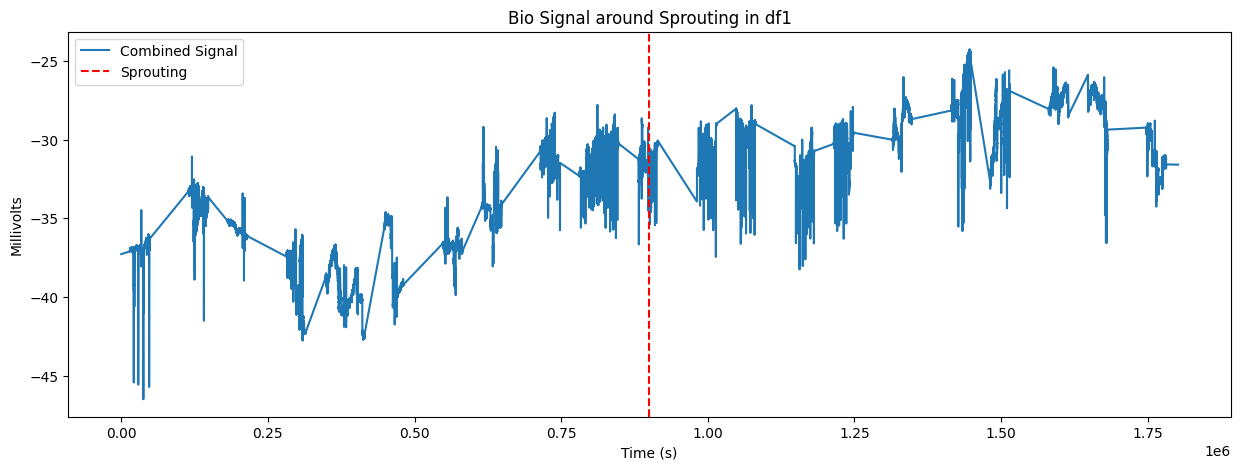

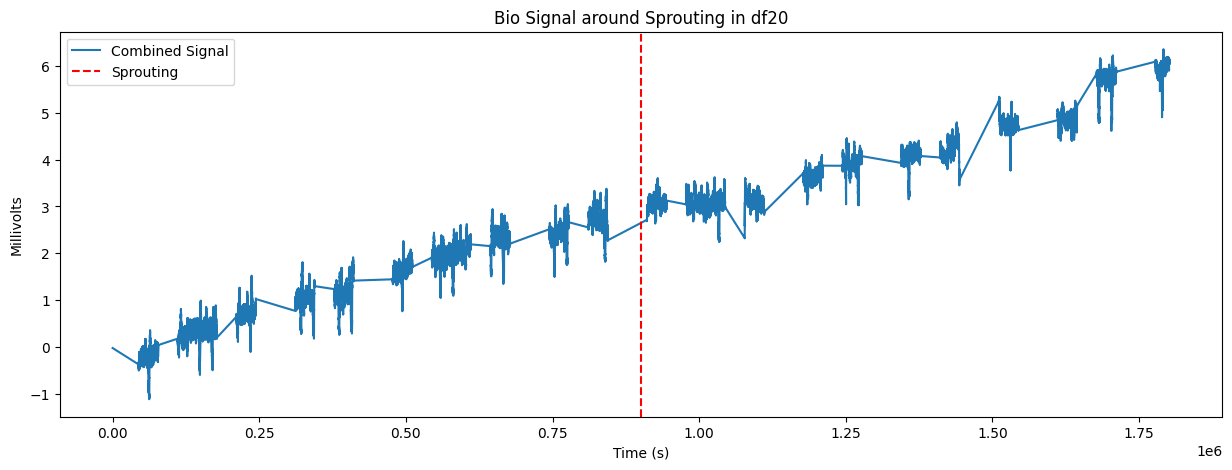

In [3]:
#before and after the sprouting
plot_bio_signal(df1, 'df1')
plot_bio_signal(df20, 'df20')

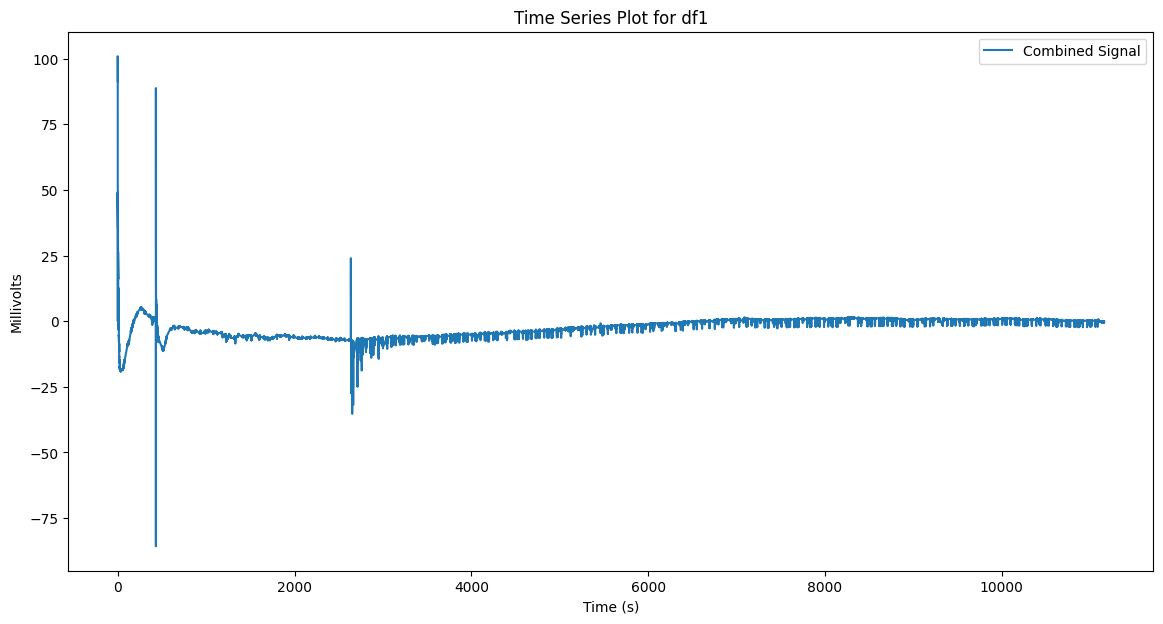

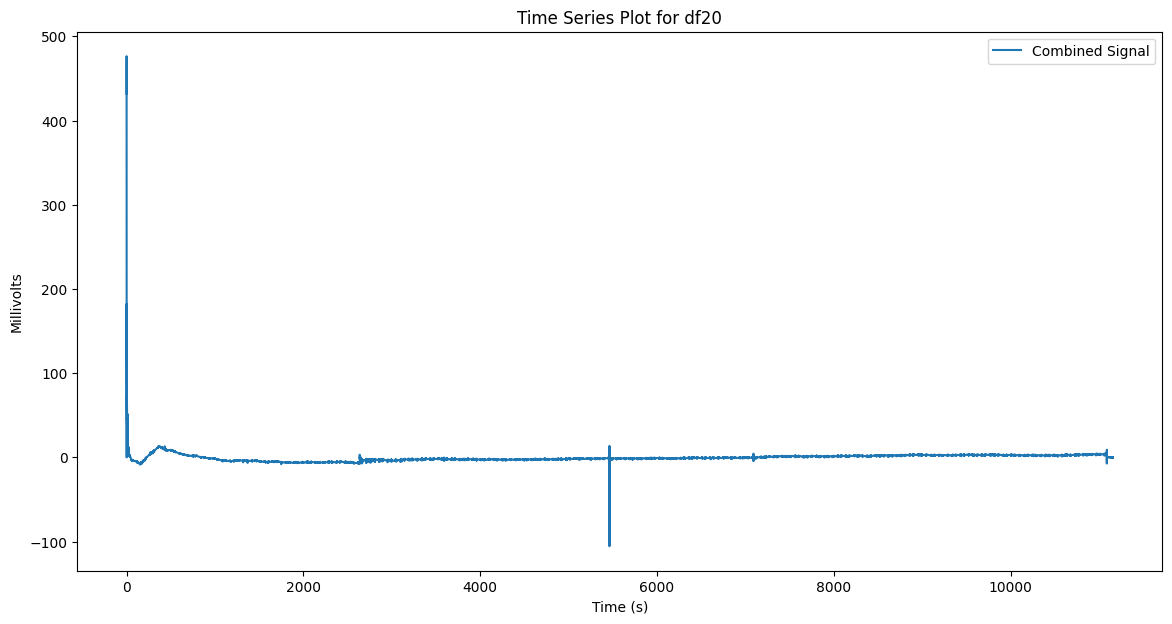

In [4]:
plot_time_series(df10, 'Time Series Plot for df1')
plot_time_series(df15, 'Time Series Plot for df20')

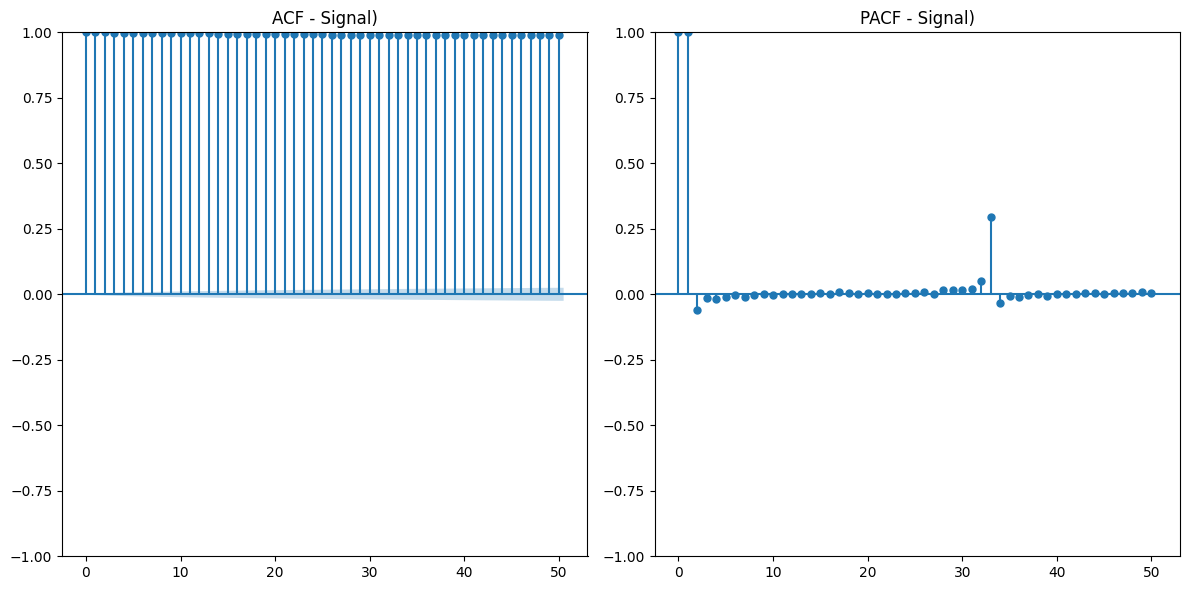

In [5]:
#ACF e PACF
filtered_df1 = df1.loc[df1['y'] <= 0]
combined_signal = filtered_df1.drop(columns='y', errors='ignore').values.flatten()
downsampled_signal = downsample_signal(combined_signal, factor=10) 
plot_acf_pacf(downsampled_signal, 'Signal)')

In [6]:
#check stationarity
stationarity_results_df1 = check_combined_stationarity_kpss(df1)
for key, value in stationarity_results_df1.items():
    print(f"{key}: {value}")

Test Statistic: 48.294028615659315
p-value: 0.01
Lags Used: 1724
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Stationarity: Non-stationary


c:\Users\stebi\Desktop\TESI\Thesis\Utils\stationarity.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(combined_signal, regression='c', nlags='auto')


In [7]:
#filter out rows with y > 0
import pandas as pd

def filter_dataframes(num_dataframes):
    filtered_dataframes = {}
    
    for i in range(1, num_dataframes + 1):
        df_name = f'df{i}'
        df = globals().get(df_name)
        if df is not None:
            filtered_df = df[df['y'] <= 0]
            filtered_dataframes[df_name] = filtered_df

    return filtered_dataframes

filtered_dataframes = filter_dataframes(32)

### Windowing

In [8]:
#windowing
processed_dataframes_6 = window(filtered_dataframes, 6)
processed_dataframes_12 = window(filtered_dataframes, 12)
processed_dataframes_18 = window(filtered_dataframes, 18)
processed_dataframes_24 = window(filtered_dataframes, 24)

### Normalization

In [9]:
#normalization
normalized_dataframes_6 = normalize(processed_dataframes_6)
normalized_dataframes_12 = normalize(processed_dataframes_12)
normalized_dataframes_18 = normalize(processed_dataframes_18)
normalized_dataframes_1_day = normalize(processed_dataframes_24)

### Feature generation

In [10]:
#featgen
extracted_features_6 = featgen(normalized_dataframes_6)
extracted_features_12 = featgen(normalized_dataframes_12)
extracted_features_18 = featgen(normalized_dataframes_18)
extracted_features_1_day = featgen(normalized_dataframes_1_day)

combined_features_6 = combined(extracted_features_6)
combined_features_12 = combined(extracted_features_12)
combined_features_18 = combined(extracted_features_18)
combined_features_1_day = combined(extracted_features_1_day)

### Scaling

In [11]:
#scaling
scaled_dataframes_6 = scale(combined_features_6, target_column='y')
scaled_dataframes_12 = scale(combined_features_12, target_column='y')
scaled_dataframes_18 = scale(combined_features_18, target_column='y')
scaled_dataframes_1_day = scale(combined_features_1_day, target_column='y')


## Regression
### Define models

In [12]:
#define models
models = {
    'XGB': XGBRegressor(),
    'ADAB': AdaBoostRegressor(),
    'LGBM': lgb.LGBMRegressor()
}

### Modelling, scaling and normalization

In [13]:
#modelling, scal + norm
dictionaries = {
    '6_h_window': scaled_dataframes_6,
    '12_h_window': scaled_dataframes_12,
    '18_h_window': scaled_dataframes_18,
    '1_d_window': scaled_dataframes_1_day
}

results, individual_maes = regression(models, dictionaries)
pretty_print(results)

Evaluating 6_h_window...
  Using model XGB...
    Average MAE: 26.0607
  Using model ADAB...
    Average MAE: 31.5529
  Using model LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6660
[LightGBM] [Info] Number of data points in the train set: 12663, number of used features: 29
[LightGBM] [Info] Start training from score -61.920003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6660
[LightGBM] [Info] Number of data points in the train set: 12634, number of used features: 29
[LightGBM] [Info] Start training from score -61.895441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You 

In [14]:
#mean day pred
mean_days = compute_mean_day_of_prediction(individual_maes)
pretty_print_mean_days(mean_days)


Mean day of prediction for 6_h_window:
  XGB: Mean prediction date and time = 2024-07-14 19:23:27.103709
  ADAB: Mean prediction date and time = 2024-07-20 07:12:14.103709
  LGBM: Mean prediction date and time = 2024-07-14 01:01:27.103709

Mean day of prediction for 12_h_window:
  XGB: Mean prediction date and time = 2024-07-14 17:15:34.103709
  ADAB: Mean prediction date and time = 2024-07-22 07:43:59.103709
  LGBM: Mean prediction date and time = 2024-07-13 06:08:44.103709

Mean day of prediction for 18_h_window:
  XGB: Mean prediction date and time = 2024-07-14 02:50:53.103709
  ADAB: Mean prediction date and time = 2024-07-22 00:00:50.103709
  LGBM: Mean prediction date and time = 2024-07-12 16:02:10.103709

Mean day of prediction for 1_d_window:
  XGB: Mean prediction date and time = 2024-07-13 19:14:15.103709
  ADAB: Mean prediction date and time = 2024-07-19 18:51:34.103709
  LGBM: Mean prediction date and time = 2024-07-11 23:29:37.103709


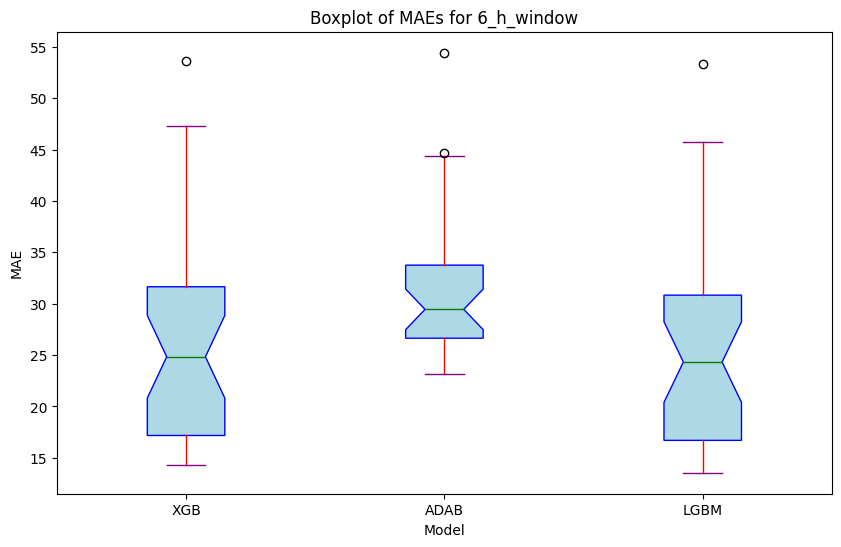

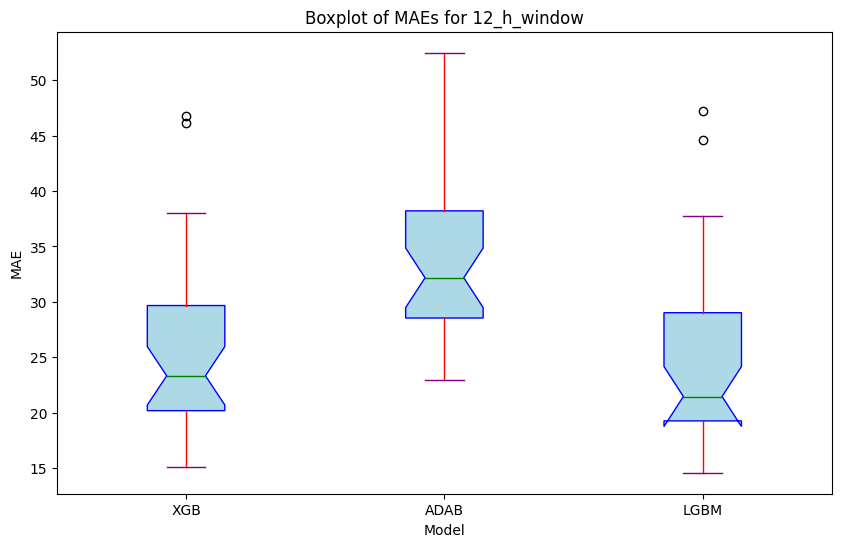

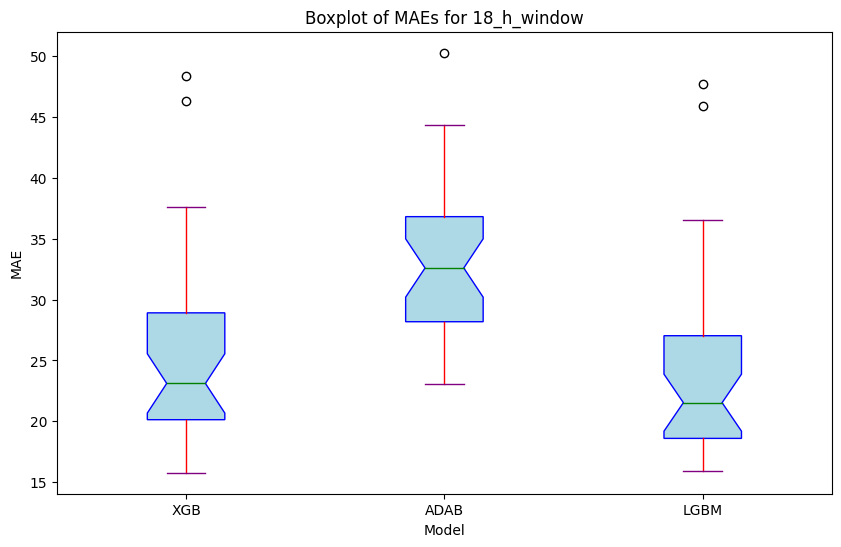

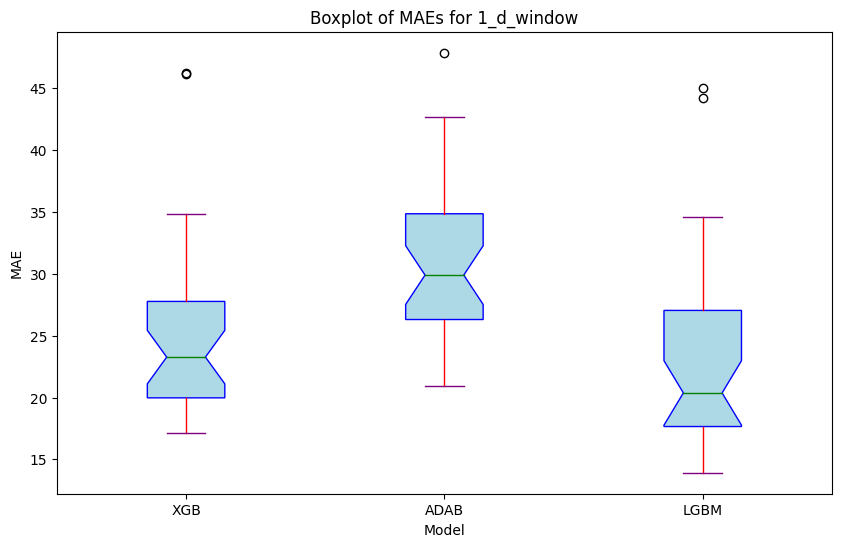

In [15]:
#boxplots
create_boxplots(individual_maes)

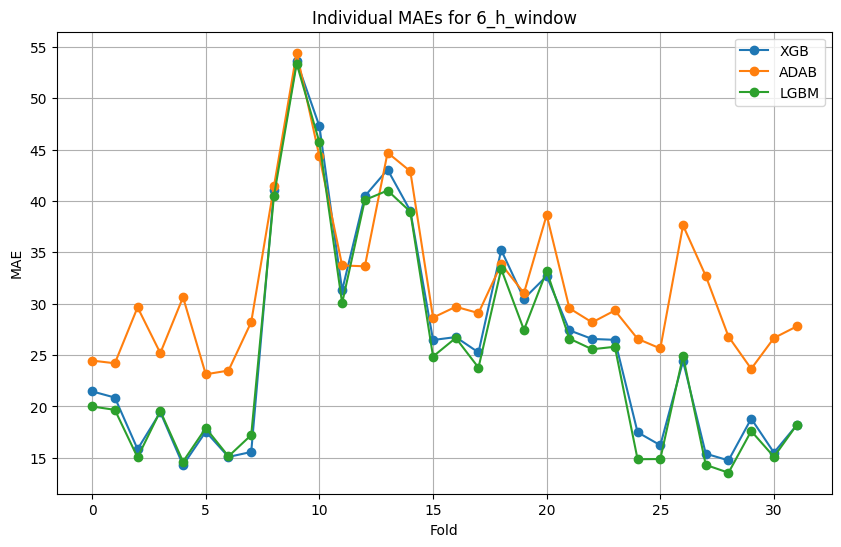

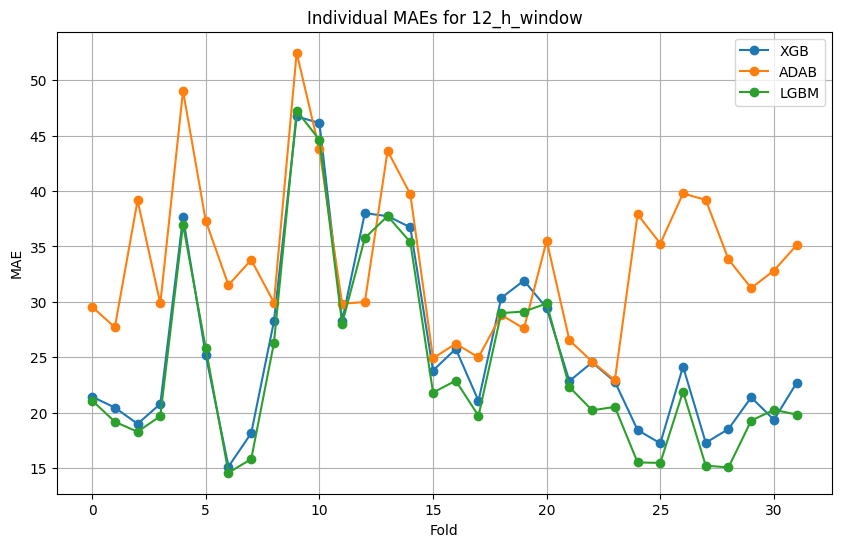

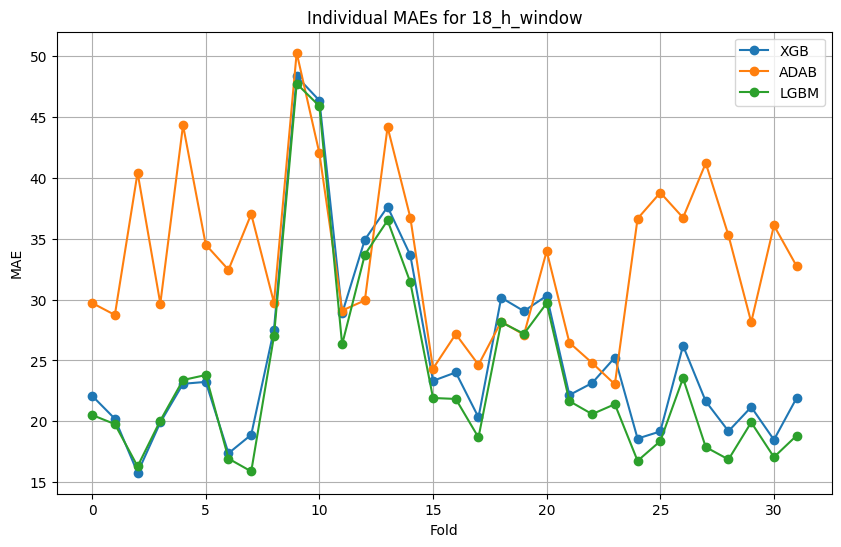

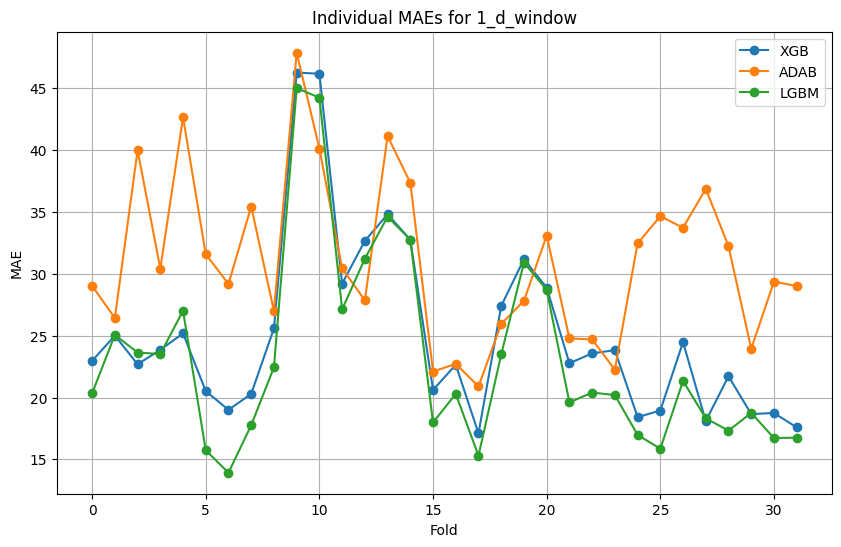

In [16]:
#line plot
plot_lines(individual_maes)

### Modelling, only normalization

In [17]:
#modelling,  only norm
dictionaries = {
    '6_h': combined_features_6,
    '12_h': combined_features_12,
    '18_h': combined_features_18,
    '1_d': combined_features_1_day
}

results, individual_maes = regression(models, dictionaries)
pretty_print(results)

Evaluating 6_h...
  Using model XGB...
    Average MAE: 35.4459
  Using model ADAB...
    Average MAE: 40.9963
  Using model LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6636
[LightGBM] [Info] Number of data points in the train set: 12663, number of used features: 27
[LightGBM] [Info] Start training from score -61.920003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6636
[LightGBM] [Info] Number of data points in the train set: 12634, number of used features: 27
[LightGBM] [Info] Start training from score -61.895441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

In [18]:
#mean day pred
mean_days = compute_mean_day_of_prediction(individual_maes)
pretty_print_mean_days(mean_days)


Mean day of prediction for 6_h:
  XGB: Mean prediction date and time = 2024-07-24 04:40:24.819272
  ADAB: Mean prediction date and time = 2024-07-29 17:53:00.819272
  LGBM: Mean prediction date and time = 2024-07-23 05:01:26.819272

Mean day of prediction for 12_h:
  XGB: Mean prediction date and time = 2024-07-24 06:31:49.819272
  ADAB: Mean prediction date and time = 2024-07-29 21:04:53.819272
  LGBM: Mean prediction date and time = 2024-07-22 20:11:03.819272

Mean day of prediction for 18_h:
  XGB: Mean prediction date and time = 2024-07-25 16:44:07.819272
  ADAB: Mean prediction date and time = 2024-07-29 10:24:59.819272
  LGBM: Mean prediction date and time = 2024-07-23 19:30:58.819272

Mean day of prediction for 1_d:
  XGB: Mean prediction date and time = 2024-07-23 15:41:42.819272
  ADAB: Mean prediction date and time = 2024-07-27 13:42:51.819272
  LGBM: Mean prediction date and time = 2024-07-21 16:54:12.819272


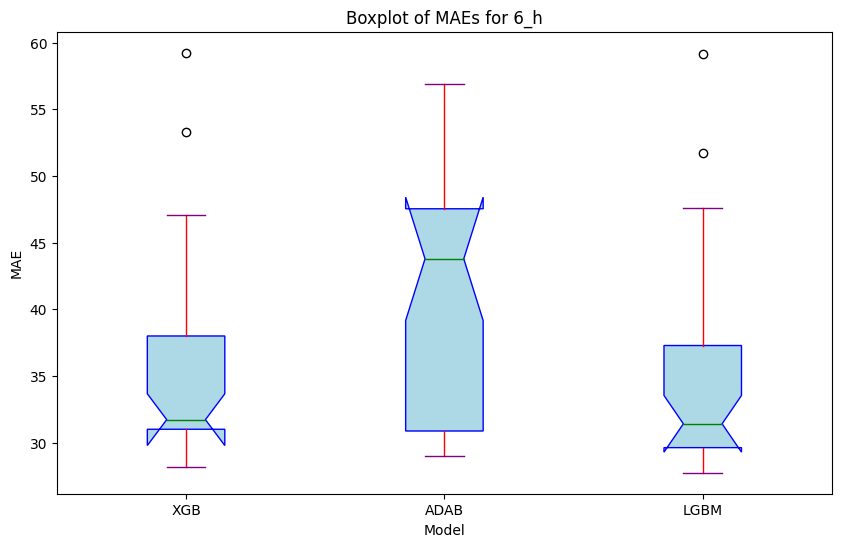

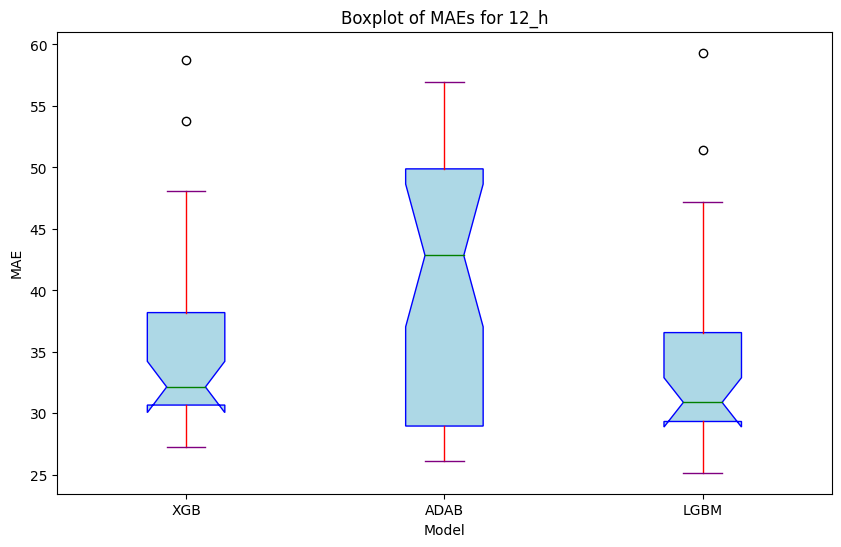

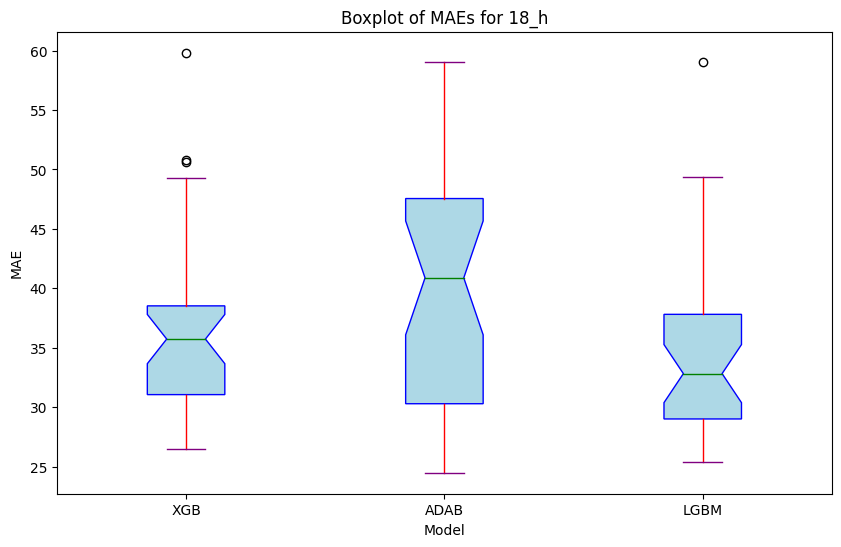

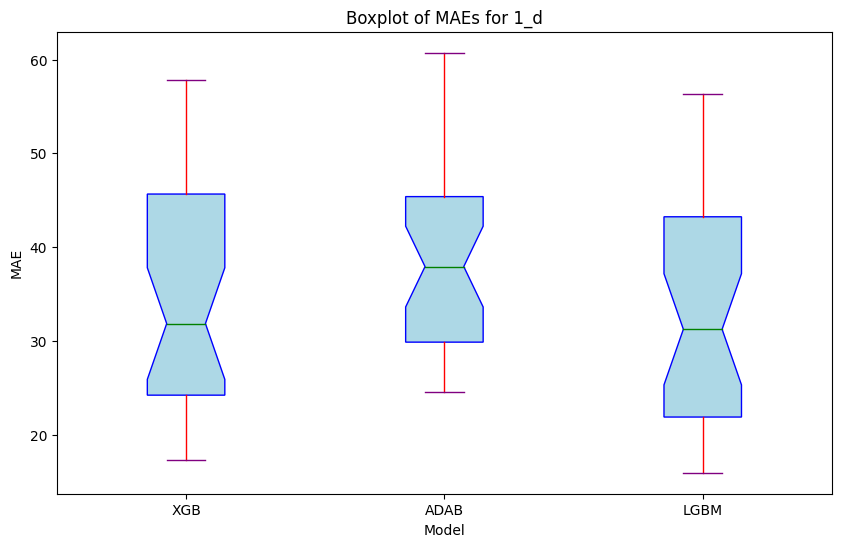

In [19]:
#boxplot
create_boxplots(individual_maes)

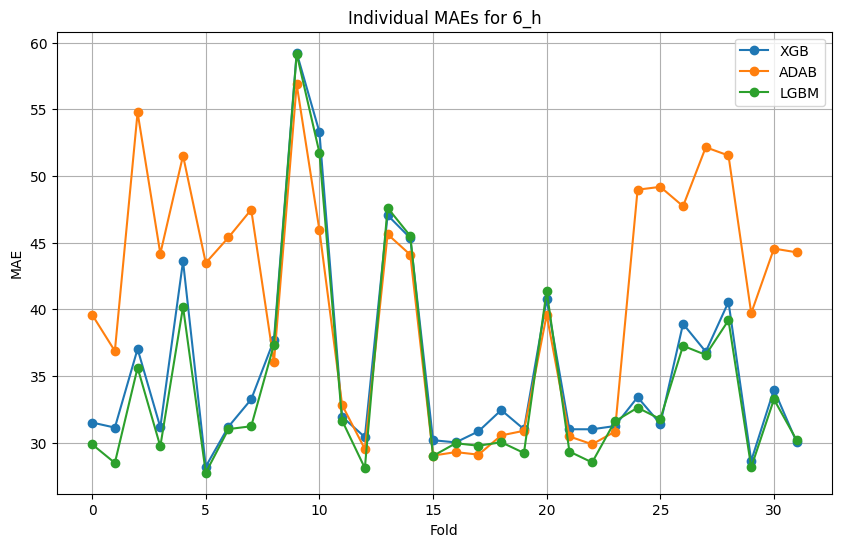

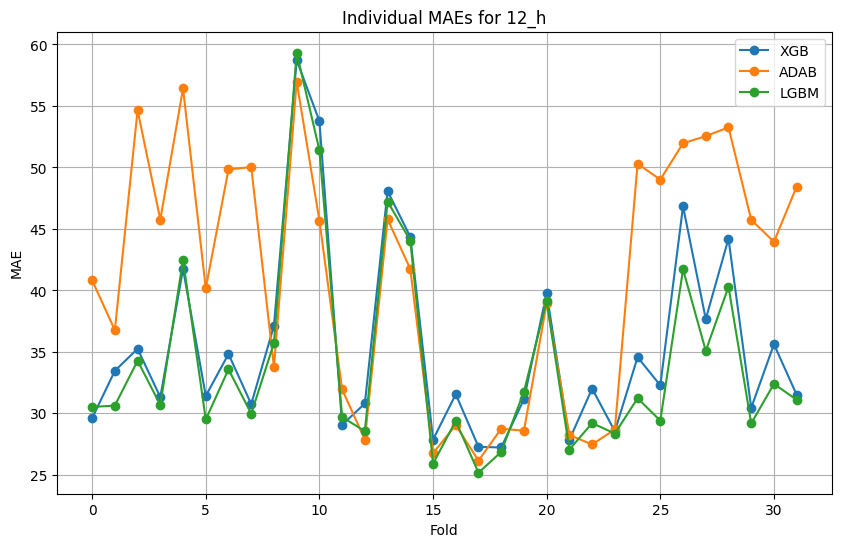

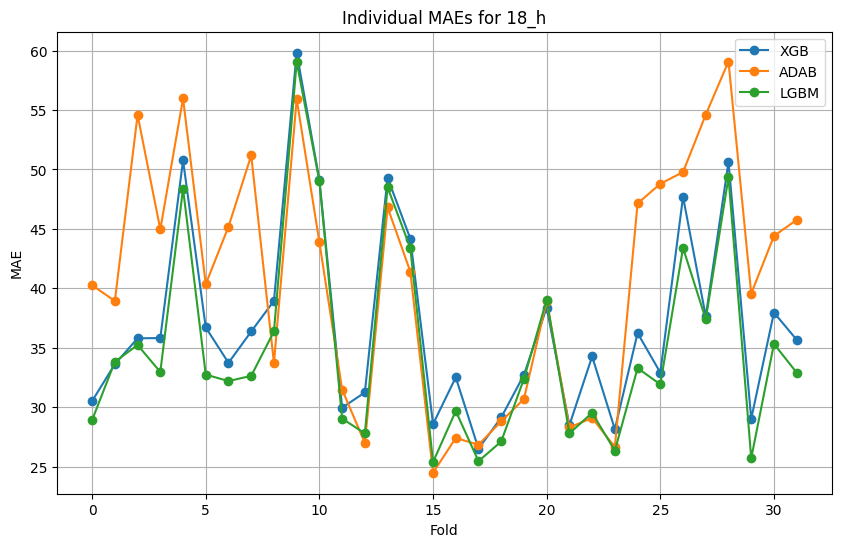

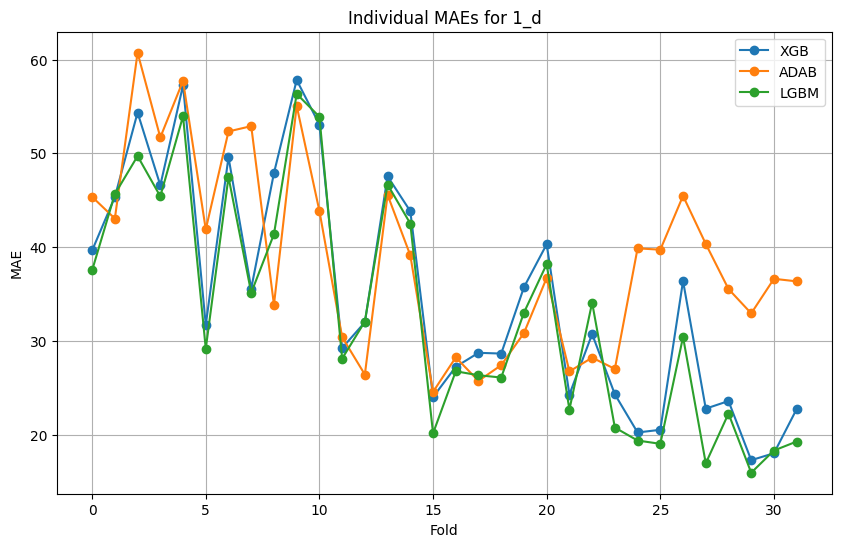

In [20]:
#line plot
plot_lines(individual_maes)

### Modelling, no scaling no normalization

In [21]:
#featgen, original data no normalization
extracted_features_6 = featgen(processed_dataframes_6)
extracted_features_12 = featgen(processed_dataframes_12)
extracted_features_18 = featgen(processed_dataframes_18)
extracted_features_1_day = featgen(processed_dataframes_24)

combined_features_6 = combined(extracted_features_6)
combined_features_12 = combined(extracted_features_12)
combined_features_18 = combined(extracted_features_18)
combined_features_1_day = combined(extracted_features_1_day)

In [22]:
#modelling, no scale no norm
dictionaries = {
    '6_h': combined_features_6,
    '12_h': combined_features_12,
    '18_h': combined_features_18,
    '1_d': combined_features_1_day
}

results, individual_maes = regression(models, dictionaries)
pretty_print(results)

Evaluating 6_h...
  Using model XGB...
    Average MAE: 34.1370
  Using model ADAB...
    Average MAE: 36.2323
  Using model LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7210
[LightGBM] [Info] Number of data points in the train set: 12663, number of used features: 29
[LightGBM] [Info] Start training from score -61.920003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7210
[LightGBM] [Info] Number of data points in the train set: 12634, number of used features: 29
[LightGBM] [Info] Start training from score -61.895441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

In [23]:
#mean day pred
mean_days = compute_mean_day_of_prediction(individual_maes)
pretty_print_mean_days(mean_days)


Mean day of prediction for 6_h:
  XGB: Mean prediction date and time = 2024-07-22 21:26:03.541086
  ADAB: Mean prediction date and time = 2024-07-24 23:43:17.541086
  LGBM: Mean prediction date and time = 2024-07-22 00:33:44.541086

Mean day of prediction for 12_h:
  XGB: Mean prediction date and time = 2024-07-20 18:53:11.541086
  ADAB: Mean prediction date and time = 2024-07-24 06:08:15.541086
  LGBM: Mean prediction date and time = 2024-07-19 18:35:41.541086

Mean day of prediction for 18_h:
  XGB: Mean prediction date and time = 2024-07-22 18:26:34.541086
  ADAB: Mean prediction date and time = 2024-07-25 05:58:31.541086
  LGBM: Mean prediction date and time = 2024-07-21 06:55:31.541086

Mean day of prediction for 1_d:
  XGB: Mean prediction date and time = 2024-07-20 17:14:20.541086
  ADAB: Mean prediction date and time = 2024-07-23 20:37:52.541086
  LGBM: Mean prediction date and time = 2024-07-20 07:02:35.541086


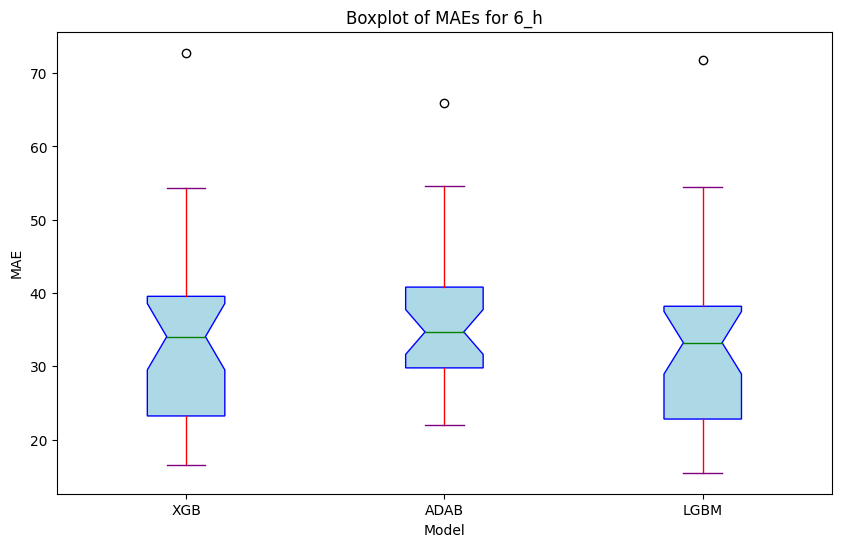

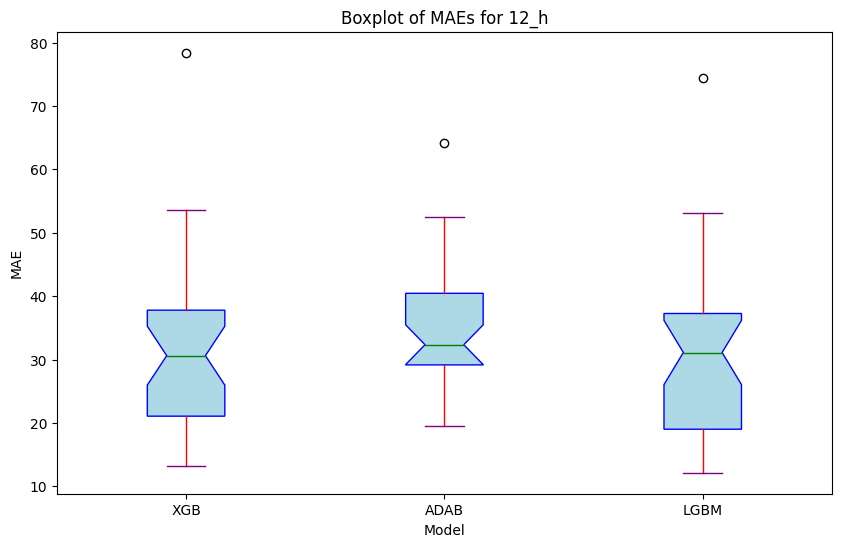

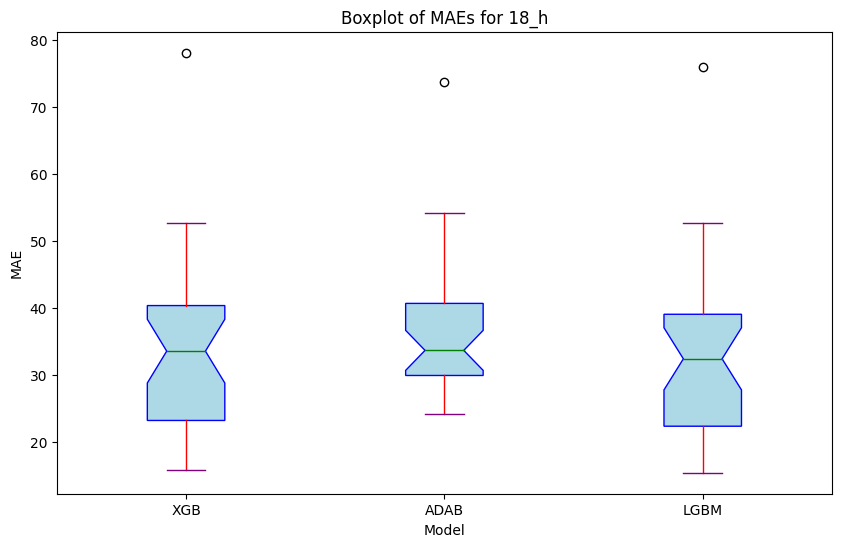

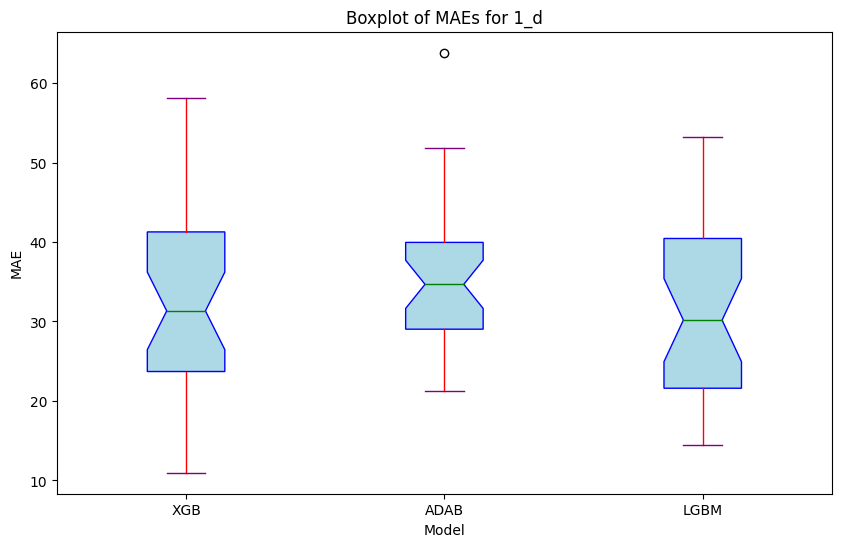

In [24]:
#boxplot
create_boxplots(individual_maes)

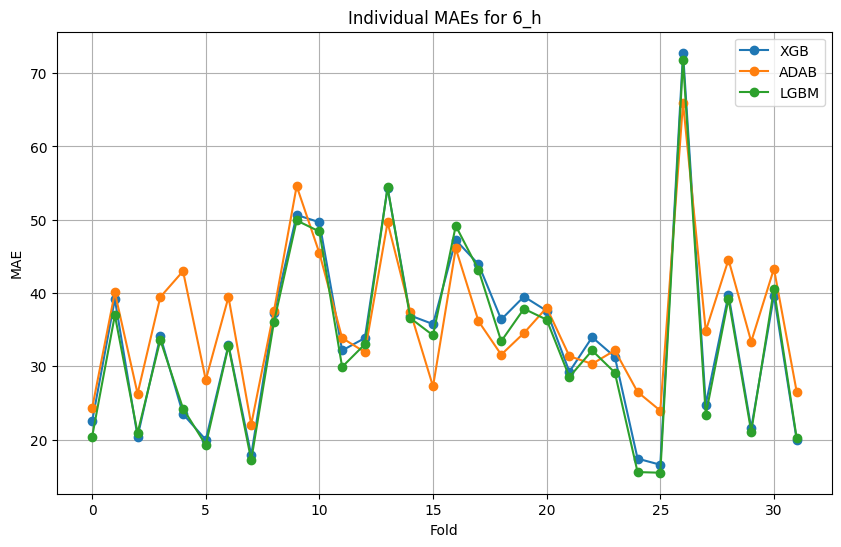

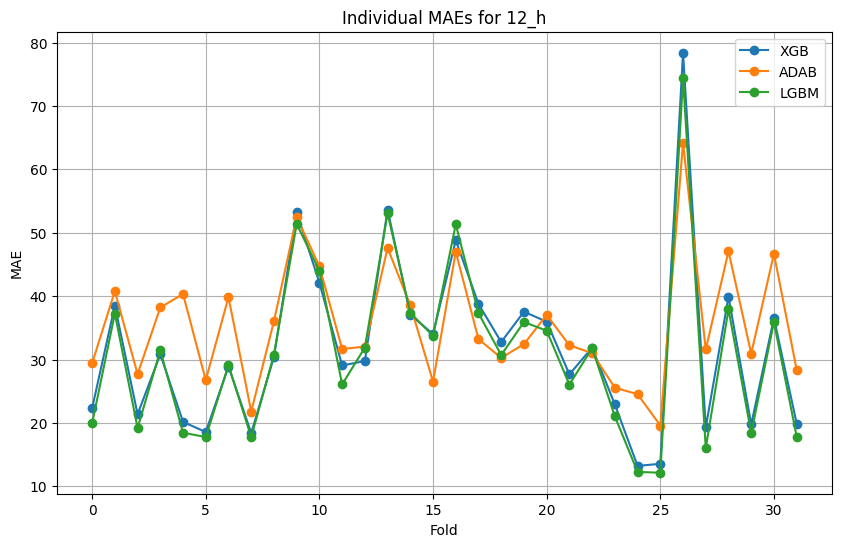

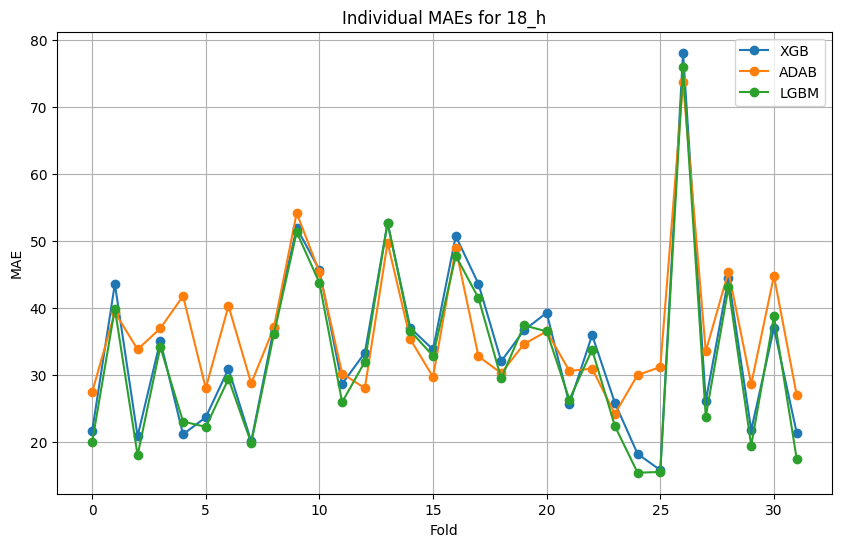

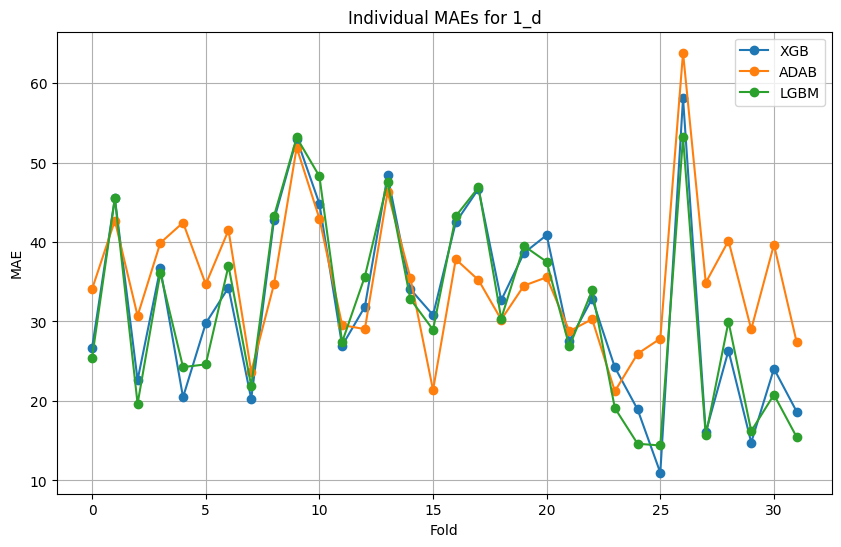

In [25]:
#line plot
plot_lines(individual_maes)

### Modelling, only scaling

In [26]:
#scaling raw data
scaled_dataframes_6 = scale(combined_features_6, target_column='y')
scaled_dataframes_12 = scale(combined_features_12, target_column='y')
scaled_dataframes_18 = scale(combined_features_18, target_column='y')
scaled_dataframes_1_day = scale(combined_features_1_day, target_column='y')

In [27]:
#modelling, only scale
dictionaries = {
    '6_h': scaled_dataframes_6,
    '12_h': scaled_dataframes_12,
    '18_h': scaled_dataframes_18,
    '1_d': scaled_dataframes_1_day
}

results, individual_maes = regression(models, dictionaries)
pretty_print(results)

Evaluating 6_h...
  Using model XGB...
    Average MAE: 25.6186
  Using model ADAB...
    Average MAE: 33.6579
  Using model LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7210
[LightGBM] [Info] Number of data points in the train set: 12663, number of used features: 29
[LightGBM] [Info] Start training from score -61.920003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7210
[LightGBM] [Info] Number of data points in the train set: 12634, number of used features: 29
[LightGBM] [Info] Start training from score -61.895441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

In [28]:
#mean day pred
mean_days = compute_mean_day_of_prediction(individual_maes)
pretty_print_mean_days(mean_days)


Mean day of prediction for 6_h:
  XGB: Mean prediction date and time = 2024-07-14 09:02:41.751105
  ADAB: Mean prediction date and time = 2024-07-22 09:59:20.751105
  LGBM: Mean prediction date and time = 2024-07-12 23:32:32.751105

Mean day of prediction for 12_h:
  XGB: Mean prediction date and time = 2024-07-15 20:04:17.751105
  ADAB: Mean prediction date and time = 2024-07-24 08:42:04.751105
  LGBM: Mean prediction date and time = 2024-07-14 21:59:00.751105

Mean day of prediction for 18_h:
  XGB: Mean prediction date and time = 2024-07-14 08:16:33.751105
  ADAB: Mean prediction date and time = 2024-07-22 13:33:55.751105
  LGBM: Mean prediction date and time = 2024-07-13 08:41:06.751105

Mean day of prediction for 1_d:
  XGB: Mean prediction date and time = 2024-07-12 11:50:21.751105
  ADAB: Mean prediction date and time = 2024-07-20 09:59:52.751105
  LGBM: Mean prediction date and time = 2024-07-11 18:28:15.751105


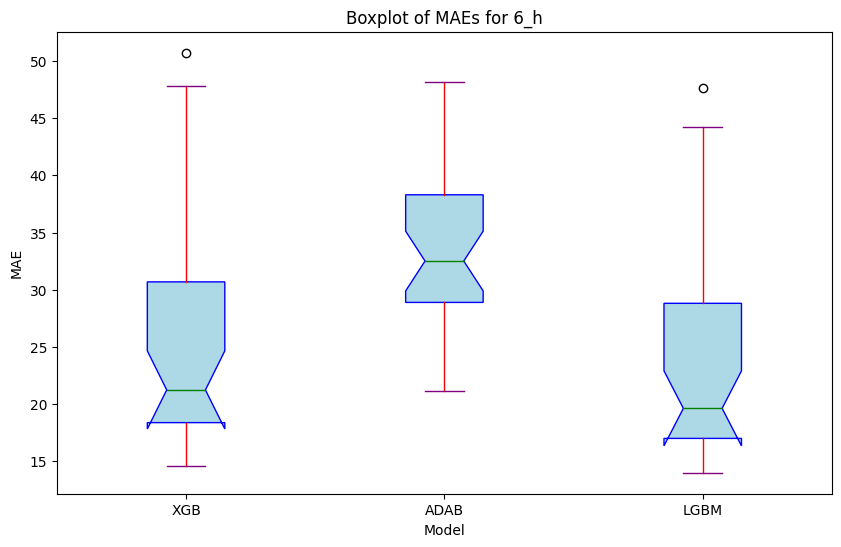

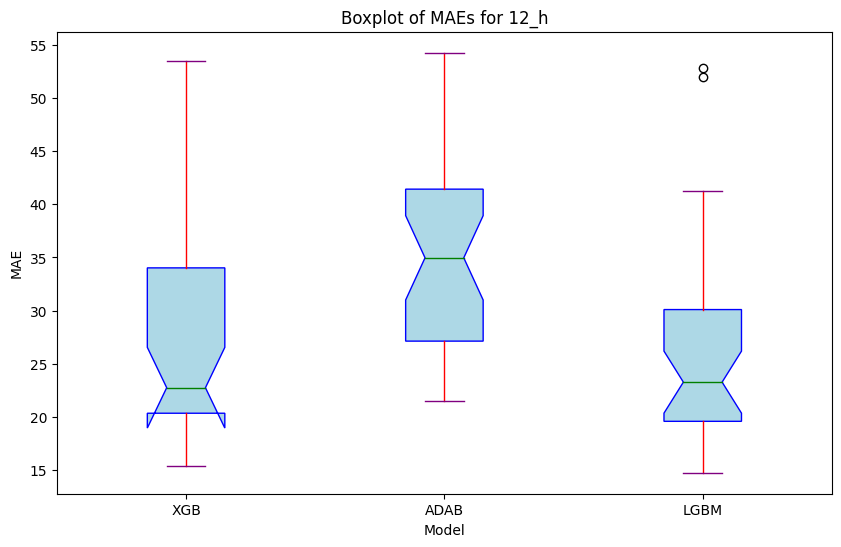

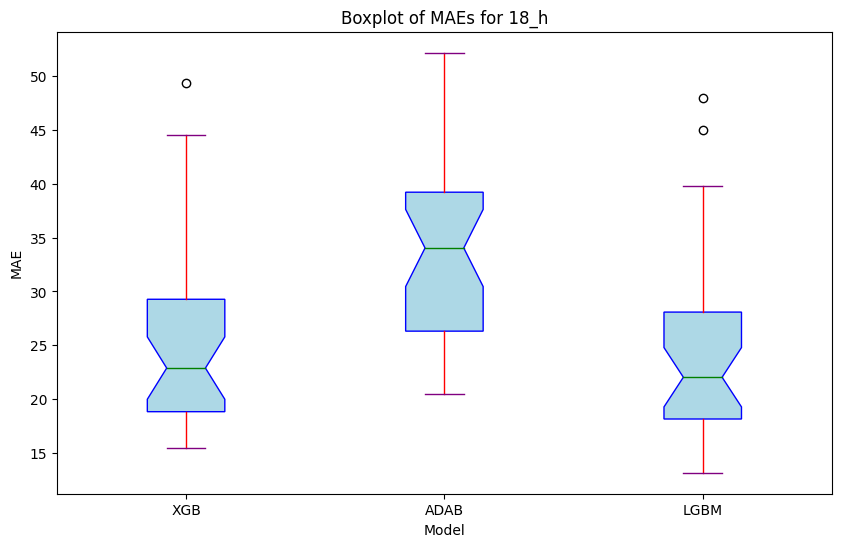

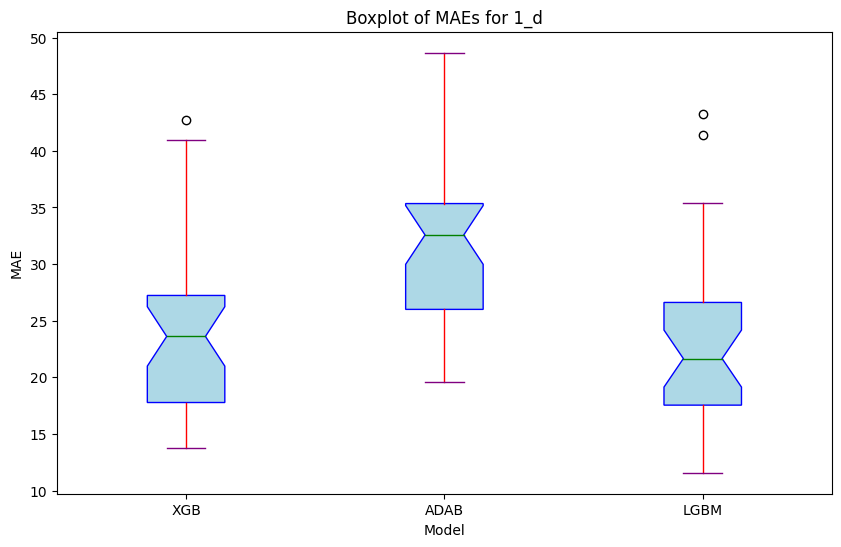

In [29]:
#boxplot
create_boxplots(individual_maes)

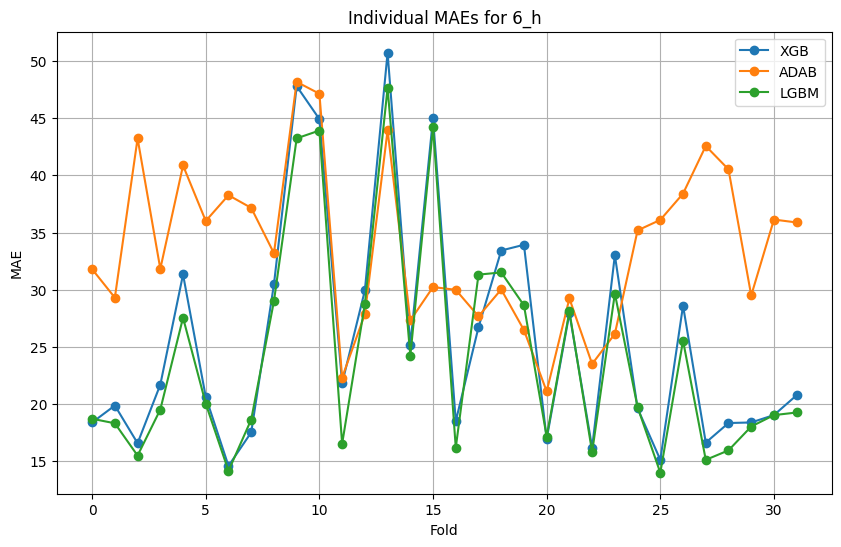

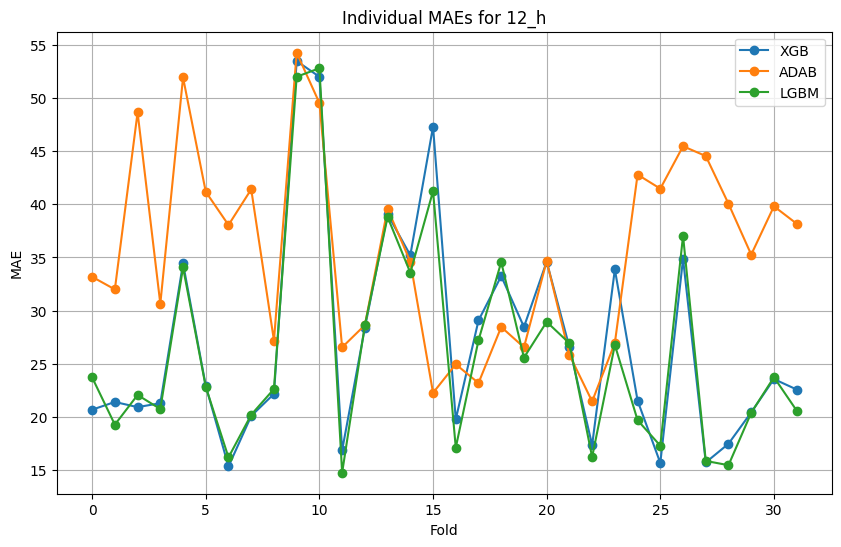

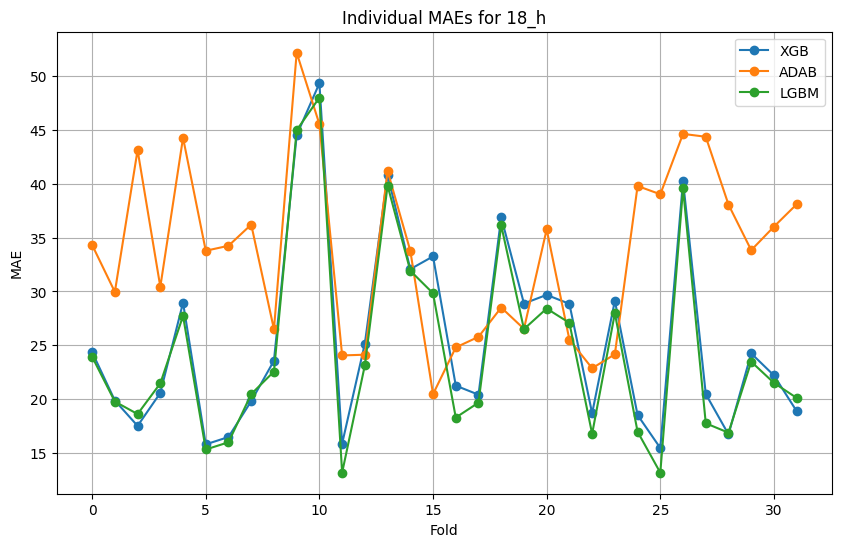

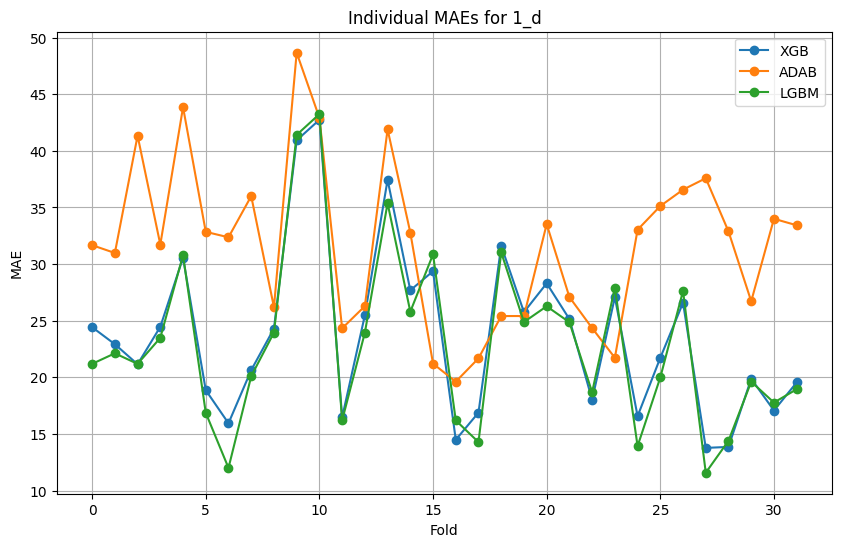

In [30]:
#line plot
plot_lines(individual_maes)